In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from wordcloud import WordCloud, STOPWORDS 

In [2]:
df = pd.read_pickle('/Users/f75k8bx/Documents/MyGitHub/NLP_using_News_API/test.pkl')

In [3]:
df_Ind = df[df.country == 'India']

In [4]:
df_Ind.shape

(9289, 9)

In [5]:
df_Ind.head()

,author,content,description,publishedAt,source.name,title,url,urlToImage,country
0,Jacob Koshy,"The spectre of COVID-19 has made its appearance in one of Indias most storied tiger reserves. The death of a 10-year-old ailing male tiger, in the Pench Tiger Reserve (PTR) the countrys most munificent reserve that succumbed to a respiratory illness last Satu… [+3272 chars]",NTCA mulls test after a big cat tested positive for the virus in a U.S. zoo,2020-04-06T18:36:02Z,The Hindu,Pench tiger death raises COVID-19 fears,https://www.thehindu.com/news/national/pench-tiger-death-raises-covid-19-fears/article31275062.ece,https://www.thehindu.com/news/national/kfposq/article31275061.ece/ALTERNATES/LANDSCAPE_615/T03,India
1,Serena Josephine M,"Every time a person tests positive for coronavirus disease (COVID-19), a process for tracing his/her contacts is activated. Exclusive teams at the State and district-level trace the path that the patient took, tracking persons with whom he/she came into conta… [+3342 chars]","As of now, officials have tracked approximately 7,000 close contacts of patients who have tested positive for COVID-19, in Tamil Nadu.",2020-04-06T11:40:08Z,The Hindu,"COVID-19: Contact tracing, a crucial exercise",https://www.thehindu.com/news/national/tamil-nadu/covid-19-contact-tracing-a-crucial-exercise/article31270966.ece,https://www.thehindu.com/news/national/tamil-nadu/bun7j2/article31270965.ece/ALTERNATES/LANDSCAPE_615/06APRTH--HOME,India
2,Shoumojit Banerjee,"The number of COVID-19 cases continued to rise in Maharashtra on April 6, with 33 new cases being reported in the State over a 12-hour span, taking the tally of positive cases to 781.\r\nOf these, Pune witnessed 19 fresh cases and 11 more have been reported fro… [+2552 chars]",33 fresh cases reported over 12-hour span,2020-04-06T09:00:34Z,The Hindu,COVID-19 | Cases in Maharashtra touch 781,https://www.thehindu.com/news/national/other-states/covid-19-cases-in-maharashtra-touch-781/article31268863.ece,https://www.thehindu.com/news/national/f3k8s8/article31160237.ece/ALTERNATES/LANDSCAPE_615/TH25MAHARASHTRATALLY,India
3,PTI,"Telangana Chief Minister K. Chandrasekhar Rao on Monday appealed to Prime Minister Narendra Modi to extend the 21-day national lockdown to check COVID-19 beyond April 14, saying it was essential to save lives.\r\nThe Telangana Rashtra Samithi supremo said it wo… [+667 chars]","It would be difficult to contain the spread of the virus in view of the country’s “poor health infrastructure”, he said.",2020-04-06T19:33:20Z,The Hindu,COVID-19 | Telangana CM favours extension of national lockdown,https://www.thehindu.com/news/national/telangana-cm-favours-extension-of-national-lockdown/article31275179.ece,https://www.thehindu.com/news/national/o7tdk5/article31275178.ece/ALTERNATES/LANDSCAPE_615/07THKCR,India
4,GUWAHATI,"Rights activists and NGOs in Manipur have written to the National Human Rights Commission (NHRC) seeking its intervention to end the alleged harassment, arbitrary arrest and detention of rights defenders.\r\nThere had been a spree of such action against these p… [+2932 chars]","Rights activists and NGOs in Manipur have written to the National Human Rights Commission (NHRC) seeking its intervention to end the alleged harassment, arbitrary arrest and detention of rights defend",2020-04-06T10:53:49Z,The Hindu,COVID-19: NHRC sounded on Manipur rights defenders’ detention,https://www.thehindu.com/news/national/other-states/covid-19-nhrc-sounded-on-manipur-rights-defenders-detention/article31270069.ece,https://www.thehindu.com/static/theme/default/base/img/og-image.jpg,India


In [6]:
df_Ind.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9289 entries, 0 to 99
Data columns (total 9 columns):
author         8881 non-null object
content        8813 non-null object
description    9288 non-null object
publishedAt    9289 non-null object
source.name    9289 non-null object
title          9289 non-null object
url            9289 non-null object
urlToImage     9229 non-null object
country        9289 non-null object
dtypes: object(9)
memory usage: 725.7+ KB


## Format Date Time 

In [7]:
df['publishedAt'][:5]

0    2020-04-06T06:22:55Z
1    2020-04-06T12:56:31Z
2    2020-04-06T11:37:52Z
3    2020-04-06T06:09:32Z
4    2020-04-06T03:47:16Z
Name: publishedAt, dtype: object

In [8]:
df['published_at'] =  pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ').dt.date
df['published_at'][:5]

0    2020-04-06
1    2020-04-06
2    2020-04-06
3    2020-04-06
4    2020-04-06
Name: published_at, dtype: object

## Discard Extra Characters From Descriptions

Example:  

The Moderator of the Presbyterian Church in Ireland has called for hope for those suffering from Covid-19 this Easter. \r\nRt Rev Dr William Henry says the peak number of confirmed virus cases is estimated to occur over the Easter weekend, which is the peak of … [+1011 chars]

I will be discarding [+1011 chars] first. I could do it after tokenization as well but I will have to make list iterations.

In [9]:
df_Ind.content[:5]

0    The spectre of COVID-19 has made its appearance in one of Indias most storied tiger reserves. The death of a 10-year-old ailing male tiger, in the Pench Tiger Reserve (PTR) the countrys most munificent reserve that succumbed to a respiratory illness last Satu… [+3272 chars]  
1    Every time a person tests positive for coronavirus disease (COVID-19), a process for tracing his/her contacts is activated. Exclusive teams at the State and district-level trace the path that the patient took, tracking persons with whom he/she came into conta… [+3342 chars]  
2    The number of COVID-19 cases continued to rise in Maharashtra on April 6, with 33 new cases being reported in the State over a 12-hour span, taking the tally of positive cases to 781.\r\nOf these, Pune witnessed 19 fresh cases and 11 more have been reported fro… [+2552 chars]
3    Telangana Chief Minister K. Chandrasekhar Rao on Monday appealed to Prime Minister Narendra Modi to extend the 21-day national lockdown to check COVI

### There are - on an average - 1.5 to 2 sentences apart from the first line available.

In [10]:
df_Ind['content_temp'] = df_Ind.content.apply(lambda x : str(x).split('…')[0])
df_Ind.content_temp[:5]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    The spectre of COVID-19 has made its appearance in one of Indias most storied tiger reserves. The death of a 10-year-old ailing male tiger, in the Pench Tiger Reserve (PTR) the countrys most munificent reserve that succumbed to a respiratory illness last Satu  
1    Every time a person tests positive for coronavirus disease (COVID-19), a process for tracing his/her contacts is activated. Exclusive teams at the State and district-level trace the path that the patient took, tracking persons with whom he/she came into conta  
2    The number of COVID-19 cases continued to rise in Maharashtra on April 6, with 33 new cases being reported in the State over a 12-hour span, taking the tally of positive cases to 781.\r\nOf these, Pune witnessed 19 fresh cases and 11 more have been reported fro
3    Telangana Chief Minister K. Chandrasekhar Rao on Monday appealed to Prime Minister Narendra Modi to extend the 21-day national lockdown to check COVID-19 beyond April 14, saying it was essential

## Title and Context Tokenization

In [11]:
from nltk import sent_tokenize, word_tokenize
import string

def text_tokenizer(text):
    if text:
        sequences = sent_tokenize(text)
        seq_tokens = [word_tokenize(seq) for seq in sequences]
        no_punct_seq_tokens = []
        for seq_token in seq_tokens:
            no_punct_seq_tokens.append([token for token in seq_token if token not in string.punctuation])
        return no_punct_seq_tokens
    else:
        return None

In [12]:
df_Ind['content_tokenized'] = df_Ind.content_temp.apply(lambda x : text_tokenizer(x))
df_Ind['content_tokenized'][:5]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    [[The, spectre, of, COVID-19, has, made, its, appearance, in, one, of, Indias, most, storied, tiger, reserves], [The, death, of, a, 10-year-old, ailing, male, tiger, in, the, Pench, Tiger, Reserve, PTR, the, countrys, most, munificent, reserve, that, succumbed, to, a, respiratory, illness, last, Satu]]    
1    [[Every, time, a, person, tests, positive, for, coronavirus, disease, COVID-19, a, process, for, tracing, his/her, contacts, is, activated], [Exclusive, teams, at, the, State, and, district-level, trace, the, path, that, the, patient, took, tracking, persons, with, whom, he/she, came, into, conta]]        
2    [[The, number, of, COVID-19, cases, continued, to, rise, in, Maharashtra, on, April, 6, with, 33, new, cases, being, reported, in, the, State, over, a, 12-hour, span, taking, the, tally, of, positive, cases, to, 781], [Of, these, Pune, witnessed, 19, fresh, cases, and, 11, more, have, been, reported, fro]]
3    [[Telangana, Chief, Minister, K., Chandrasekhar, Rao, on

In [ ]:
import os
from nltk.tag import StanfordPOSTagger

path = os.getcwd()
path_to_stnfrd_core_nlp = path + '/stanford-postagger/'

jar = path_to_stnfrd_core_nlp + 'stanford-postagger.jar'
model = path_to_stnfrd_core_nlp + 'models/english-bidirectional-distsim.tagger'

st = StanfordPOSTagger(model, jar, encoding='utf8')

In [ ]:
from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

lm = WordNetLemmatizer()

dict_pos_map = {
    # Look for NN in the POS tag because all nouns begin with NN
    'NN': NOUN,
    # Look for VB in the POS tag because all nouns begin with VB
    'VB':VERB,
    # Look for JJ in the POS tag because all nouns begin with JJ
    'JJ' : ADJ,
    # Look for RB in the POS tag because all nouns begin with RB
    'RB':ADV  
}

def get_lemma(no_punct_seq_tokens):
    try:
        if no_punct_seq_tokens:
            normalized_sequence = []
            for each_seq in st.tag_sents(sentences=no_punct_seq_tokens):
                normalized_tokens = []
                for tuples in each_seq:
                    temp = tuples[0]
                    if tuples[1] == "NNP" or tuples[1] == "NNPS":
                        continue
                    if tuples[1][:2] in dict_pos_map.keys():
                        temp = lm.lemmatize(tuples[0].lower(), 
                                            pos=dict_pos_map[tuples[1][:2]])
                    normalized_tokens.append(temp)
                normalized_sequence.append(normalized_tokens)
            return normalized_sequence
        else:
            return None
    except:
        print(no_punct_seq_tokens)
        return None

In [ ]:
df_Ind['normalized_sequence'] = df_Ind.content_tokenized.apply(lambda x: get_lemma(x))
df_Ind['normalized_sequence'][:5]

In [ ]:
from datetime import datetime

print("Start: " + str(datetime.now()))

df_Ind['title_tokenized'] = df_Ind.title.apply(lambda x : text_tokenizer(x))
print("Tokenization Done!")

df_Ind['normalized_title'] = df_Ind.title_tokenized.apply(lambda x: get_lemma(x))
print("Normalization Done!")

print("End: " + str(datetime.now()))

In [ ]:
df_Ind['normalized_title'][:5]

In [ ]:
from datetime import datetime

print("Start: " + str(datetime.now()))
      
df_Ind['description_tokenized'] = df_Ind.description.apply(lambda x : text_tokenizer(x))
print("Tokenization Done!")

df_Ind['normalized_description'] = df_Ind.description_tokenized.apply(lambda x: get_lemma(x))
print("Normalization Done!")

print("End: " + str(datetime.now()))

## Word Cloud Generation

In [ ]:
def generate_wordcloud(token_sequences):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width = 800, height = 800, max_words = 20, normalize_plurals = True,
                background_color ='white', 
                stopwords = stopwords).generate(token_sequences)

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

In [ ]:
def get_top_frequence(seq = True, df, column_name):
    df[column_name]

In [15]:
df_Ind.content_tokenized[:1]

0    [[The, spectre, of, COVID-19, has, made, its, appearance, in, one, of, Indias, most, storied, tiger, reserves], [The, death, of, a, 10-year-old, ailing, male, tiger, in, the, Pench, Tiger, Reserve, PTR, the, countrys, most, munificent, reserve, that, succumbed, to, a, respiratory, illness, last, Satu]]
Name: content_tokenized, dtype: object

In [21]:
list_i = [k for i in list(df_Ind['title_tokenized']) for j in i for k in j]

In [22]:
list_i

['Pench',
 'tiger',
 'death',
 'raises',
 'COVID-19',
 'fears',
 'COVID-19',
 'Contact',
 'tracing',
 'a',
 'crucial',
 'exercise',
 'COVID-19',
 'Cases',
 'in',
 'Maharashtra',
 'touch',
 '781',
 'COVID-19',
 'Telangana',
 'CM',
 'favours',
 'extension',
 'of',
 'national',
 'lockdown',
 'COVID-19',
 'NHRC',
 'sounded',
 'on',
 'Manipur',
 'rights',
 'defenders',
 '’',
 'detention',
 'First',
 'COVID-19',
 'patient',
 'discharged',
 'from',
 'hospital',
 'in',
 'DK',
 'Fourteen',
 'new',
 'COVID-19',
 'positive',
 'cases',
 'reported',
 'in',
 'Andhra',
 'Pradesh',
 'COVID-19',
 'Nellore',
 'Prakasam',
 'report',
 '4',
 'new',
 'cases',
 'COVID',
 'relief',
 'Bar',
 'Council',
 'invites',
 'online',
 'applications',
 'from',
 'advocates',
 '12',
 'new',
 'COVID-19',
 'cases',
 'reported',
 'in',
 'Karnataka',
 '772',
 'attend',
 'interviews',
 'for',
 'paramedics',
 'staff',
 'at',
 'COVID-19',
 'centres',
 'TN',
 'School',
 'Education',
 'Department',
 'to',
 'contribute',
 '₹70',
 '

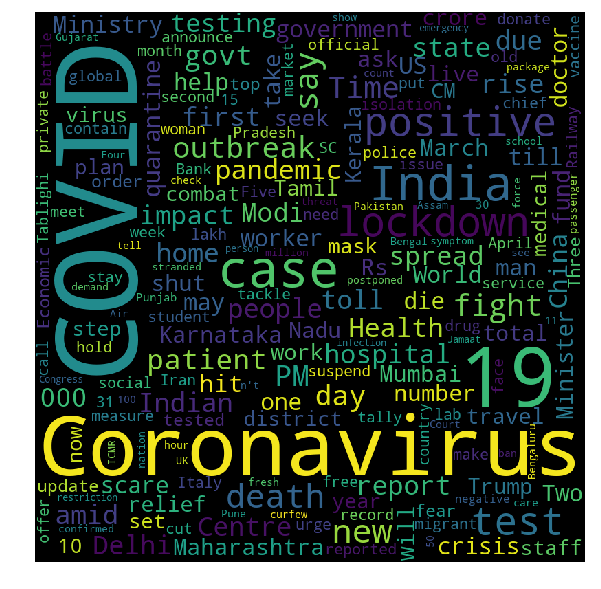

In [32]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, max_words = 200, normalize_plurals = True,
            background_color ='black', relative_scaling = 0.5, collocations = False, include_numbers = True,
            stopwords = stopwords).generate(' '.join(list_i))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [33]:
wordcloud.words_

{'COVID': 1.0,
 'Coronavirus': 0.9598132737974426,
 '19': 0.9523036330424193,
 'case': 0.21534402273188552,
 'India': 0.1938299167850619,
 'lockdown': 0.13131723158108383,
 'positive': 0.12705500304444894,
 'test': 0.12035721534402273,
 'new': 0.09234828496042216,
 'say': 0.08889790947838441,
 'death': 0.0870712401055409,
 'fight': 0.0732697381773899,
 'Time': 0.07164603206819566,
 'outbreak': 0.06758676679521007,
 'PM': 0.06413639131317232,
 'patient': 0.060077126040186724,
 'govt': 0.05967119951288817,
 'day': 0.05926527298558961,
 'due': 0.05297341181246194,
 'amid': 0.05175563223056627,
 'state': 0.05094377917596915,
 'home': 0.04972599959407347,
 'Indian': 0.049117109803125635,
 'people': 0.04891414653947636,
 'report': 0.048305256748528515,
 'pandemic': 0.048305256748528515,
 'Health': 0.04769636695758068,
 'Modi': 0.04505784453014004,
 'spread': 0.04424599147554293,
 'rise': 0.04363710168459509,
 'impact': 0.042825248629997974,
 'first': 0.04181043231175157,
 'Centre': 0.0414045